$$
\begin{array}{c}
\textbf{CONTINUING STATISTICS AND INTRODUCTION TO EXPERIMENTS}\\\\\\\\
\textbf{Daniela Pinto Veizaga, Xiang Pan, and Xiang Gao} \\
\textit{Center for Data Science, New York University} \\\\\\
\textit{September 27, 2024}
\end{array}
$$


## 0. Recap From Last Class
- Fundamental concepts in statistics, such as samples, estimators, it's properties and the central limit theorem.

## 1. Goals For Today
- Review hypothesis testing and errors, introduce experiments for causal inference, and apply these ideas to evaluate job training programs' impact on wages using a real-world case study.


## 2. Motivating Case: The Effect of a Training Program on Wages


Experiments are a powerful method for conducting causal inference across various fields. Randomized Controlled Trials (RCTs) are especially useful because they allow us to study the effect of a treatment by randomly assigning it to different units. Let's explore an experiment in the context of job training programs.


### 2.1) Context

In the 1970s, the National Supported Work (NSW) Demonstration rolled out a big job training program to help people who were struggling to find or keep a job. The program offered not only guaranteed employment but also some handy counseling to give participants a boost.

Because participants were randomly assigned to either get the job training or not, this creates a _natural experiment_. Random assignment helps us be more confident that any differences in wages between the two groups are due to the job training itself, not other factors. You can read more about it [here](https://econpapers.repec.org/article/aeaaecrev/v_3a76_3ay_3a1986_3ai_3a4_3ap_3a604-20.htm).

### 2.2) Data

The dataset for the NSW experiment consisted of two groups, _treated_ participants who were enrolled in the job training program, and _control_ individuals who were eligible but did not receive the job training.

The dataset from the NSW experiment includes:

- Treatment Indicator: 1 if the individual received job training, 0 if not. Denoted by $\text{treat}$.

- Outcome: The outcomes of interest is the annual wages in 1974, 1975, and 1978, denoted as $\text{re74}, \text{re75}$, and $\text{re78}$ respectively.
- Other Factors: Variables that may affect wages such as age, education, race, marital status, and prior earnings.



More on the data can be found [here](https://search.r-project.org/CRAN/refmans/designmatch/html/lalonde.html)



In [25]:
import pandas as pd

url_base = 'http://www.nber.org/~rdehejia/data/nswre74_'
cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75', 're78']
dfs = [pd.read_csv(f'{url_base}{group}.txt', sep='\s+', header=None, names=cols) for group in ['control', 'treated']]
data = pd.concat(dfs, ignore_index=True)
# Add binary indicators for zero income in 1974 and 1975
data[['u74', 'u75']] = (data[['re74', 're75']] == 0).astype(float)

In [26]:
# Summary statistics of the dataset
data.describe()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
count,445.000000,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,0.415730,25.370787,10.195506,0.833708,0.08764,0.168539,0.782022,2102.265311,1377.138368,5300.763699,0.732584,0.649438
std,0.493402,7.100282,1.792119,0.372762,0.28309,0.374766,0.413337,5363.582400,3150.960771,6631.491695,0.443109,0.477683
min,0.000000,17.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,24.000000,10.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.812000,1.000000,1.000000
75%,1.000000,28.000000,11.000000,1.000000,0.00000,0.000000,1.000000,824.388900,1220.836000,8124.715000,1.000000,1.000000
max,1.000000,55.000000,16.000000,1.000000,1.00000,1.000000,1.000000,39570.680000,25142.240000,60307.930000,1.000000,1.000000


In [27]:
# Checking the distribution of the treatment variable
print(data['treat'].value_counts())

treat
0.0    260
1.0    185
Name: count, dtype: int64



One way to verify the randomization worked properly is to ensure **covariate balance** between treated and control groups.

In [28]:
# Check balance in pre-treatment covariates
covariates = ['age', 'educ', 're74', 're75']

# Mean comparison of covariates
print("Mean Comparison of Covariates:")
print(data.groupby('treat')[covariates].mean())

Mean Comparison of Covariates:
             age       educ         re74         re75
treat                                                
0.0    25.053846  10.088462  2107.026658  1266.909002
1.0    25.816216  10.345946  2095.573689  1532.055314


### 2.3) Average Treatment Effect (ATE)

Before proceeding, we assume:

+ _Perfect Compliance_: Everyone follows the assigned treatment, meaning each unit receives the treatment exactly as assigned. To evaluate this, check the treatment assignment and whether anyone received a treatment they were not assigned or did not receive a treatment they were assigned.
+ _SUTVA (Stable Unit Treatment Value Assumption)_: Outcomes for one unit do not depend on the treatment status of others.

Thus, the ATE can be estimated using the difference in means:
  $$
  \text{ATE} = \mathbb{E}[Y(1, U) - Y(0, U)]
  $$

  where:
  - $Y(1, U) $ is the wage with treatment.
  - $ Y(0, U) $ is the wage without treatment.

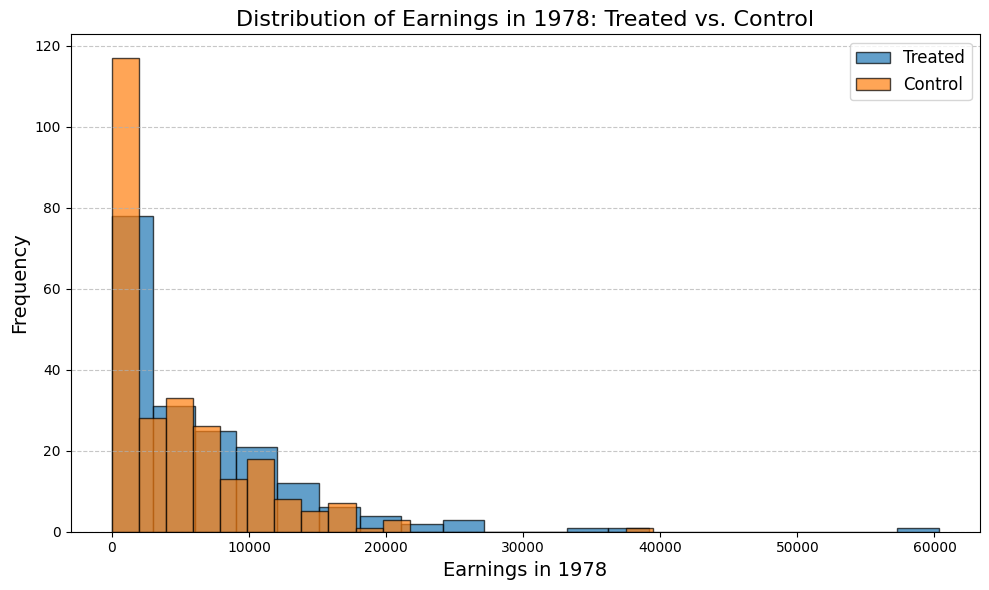

In [29]:
import matplotlib.pyplot as plt

# Define colors and styles
colors = ['#1f77b4', '#ff7f0e']
labels = ['Treated', 'Control']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(treated['re78'], bins=20, alpha=0.7, color=colors[0], edgecolor='black', label=labels[0])
plt.hist(control['re78'], bins=20, alpha=0.7, color=colors[1], edgecolor='black', label=labels[1])

# Add labels, title, and legend
plt.xlabel('Earnings in 1978', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Earnings in 1978: Treated vs. Control', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [30]:
# Calculate the mean outcomes for treated and control groups
mean_treated = treated['re78'].mean()
mean_control = control['re78'].mean()

# Calculate the ATE as the difference in means
ate = mean_treated - mean_control
print(f"Estimated ATE (Difference in Means): {ate:.2f}")

Estimated ATE (Difference in Means): 1794.34


**Implications** On average, individuals who received the job training program earned $1794.34 more per year than those who did not receive the training. **How confident are we on this results?**

### 2.4) Assessing the Treatment Effects

To determine if the job training program genuinely impacts outcomes such as wages, we use hypothesis testing to statistically validate our findings. This involves testing if observed effects are significant or due to chance, analyzing potential errors to ensure accuracy, and applying decision rules to guide our conclusions. This process ensures that our results are reliable and actionable, enabling informed decisions about the treatment’s effectiveness.

#### Hypothesis Testing for the ATE

We are testing the Average Treatment Effect (ATE) to determine if job training programs have a significant impact on wages.


- $H_0$: The treatment has no effect on the outcome.
  $$
  H_0: \text{ATE} = 0
  $$
- $H_1$: The treatment has an effect on the outcome.
  $$
  H_1: \text{ATE} \neq 0
  $$

#### Standard Error (SE)
The standard error of the difference in means is calculated as:
  $$
  \text{SE} = \sqrt{\frac{\text{Var}[Y_i(1)]}{n_{\text{treated}}} + \frac{\text{Var}[Y_i(0)]}{n_{\text{control}}}}
  $$
  where $\text{Var}[Y_i(1)]$ and $\text{Var}[Y_i(0)]$ are the variances of the outcome in the treated and control groups, respectively.

#### Test Statistic ($ T_n$)

This is computed as:
 $$
  T_n = \frac{\text{ATE}}{\text{SE}}
 $$
  where $\text{ATE} = \mathbb{E}[Y_i(1)] - \mathbb{E}[Y_i(0)]$.

#### P-Value

The probability of observing a test statistic as extreme as $T_n $ under the null hypothesis $ H_0 $:
  $$
  \text{p-value} = 2 \cdot \left(1 - \Phi(\left|T_n\right|)\right)
  $$
  where $\Phi$ is the CDF of the standard normal distribution.

In [31]:
import numpy as np
from scipy import stats

# Calculate standard deviations and sample sizes
std_treated = treated['re78'].std()
std_control = control['re78'].std()
n_treated = treated.shape[0]
n_control = control.shape[0]

# Standard error of the difference in means
se = np.sqrt((std_treated**2 / n_treated) + (std_control**2 / n_control))

# Test statistic
t_stat = ate / se

# p-value for two-sided test
p_value = 2 * (1 - stats.norm.cdf(np.abs(t_stat)))
print(f"Test Statistic: {t_stat:.2f}")
print(f"P-Value: {p_value:.4f}")



Test Statistic: 2.67
P-Value: 0.0075




#### Analyzing Error Types

**Type I Error** (False Positive): Occurs if we reject $ H_0$ when $H_0 $ is true. This error is controlled by our significance level $\alpha $.

**Type II Error** (False Negative): Occurs if we fail to reject $ H_0 $ when $ H_0 $ is false. The probability of this error is related to the power of the test, which increases with the sample size and the magnitude of the treatment effect.

####  Critical Value and Decision Rule
- **Critical Value ($c$)**: The threshold for rejecting $H_0$, determined as:
  $$
  c = \Phi^{-1}\left(1 - \frac{\alpha}{2}\right)
  $$
  where $\Phi^{-1}$ is the inverse CDF of the standard normal distribution.

- **Decision Rule**: We reject $ H_0 $if:
  $$
  \left| T_n \right| > c
  $$


In [32]:
alpha = 0.05  # significance level

# Determine the critical value for the given significance level
critical_value = stats.norm.ppf(1 - alpha / 2)
print(f"Critical Value (c) for α={alpha}: {critical_value:.2f}")

# Decision Rule: Reject H0 if |Tn| > c
reject_null = abs(t_stat) > critical_value
print(f"Reject Null Hypothesis (H0): {reject_null}")

# Interpretation of the ATE
print(f"Estimated ATE: ${ate:.2f}")

if p_value < alpha:
    significance = "significant"
else:
    significance = "not significant"

print(f"The p-value of {p_value:.4f} indicates that the observed ATE is {significance} and suggests a significant impact of the treatment.")


Critical Value (c) for α=0.05: 1.96
Reject Null Hypothesis (H0): True
Estimated ATE: $1794.34
The p-value of 0.0075 indicates that the observed ATE is significant and suggests a significant impact of the treatment.


## 3. Path Forward

+ Advanced Experiment Designs: Learn about more complex setups like testing multiple factors at once or studying changes over time.